# Automação de preenchimento de tabelas e geração de gráficos

O script faz o scraping de dados sobre inflação, preço do petróleo e diesel, gerando gráficos e preenchendo tabelas utilizadas no Boletim Econômico e Regulatório da AGEPAR.

> Autor: Matheus Brasil

## Navegação <a id="nav"></a>

O notebook está estrutura da seguinte e forma e você pode utilizar os links abaixos para navegação.  

- [Pacotes](#pacotes)
- [Coleta e Tratamento de Dados](#coleta-tratamento)
    - [IPCA](#coleta-tratamento-ipca)
        - [Nacional](#coleta-tratamento-ipca-nacional)
        - [Regiões](#coleta-tratamento-ipca-regioes)
        - [Curitiba](#coleta-tratamento-ipca-curitiba)
    - [INPC](#tratamento-inpc)
        - [Nacional](#coleta-tratamento-inpc-nacional)
        - [Regiões](#coleta-tratamento-inpc-regioes)
        - [Curitiba](#coleta-tratamento-inpc-curitiba)
    - [Preços Monitorados](#coleta-tratamento-monitorados)
    - [IGP-DI](#coleta-tratamento-igpdi)
    - [IPG-M](#coleta-tratamento-igpm)
    - [Brent](#coleta-tratamento-brent)
    - [Diesel](#coleta-tratamento-diesel)
- [Gráficos e Tabelas](#graficos)
    - [IPCA](#graficos-ipca)
        - [Nacional](#graficos-ipca-nacional)
        - [Regiões](#graficos-ipca-regioes)
        - [Curitiba](#graficos-ipca-curitiba)
    - [INPC](#graficos-inpc)
        - [Nacional](#graficos-inpc-nacional)
        - [Regiões](#graficos-inpc-regioes)
        - [Curitiba](#graficos-inpc-curitiba)
    - [Preços Monitorados](#graficos-monitorados)
    - [IGP-DI](#graficos-igpdi)
    - [IGP-M](#graficos-igpm)
    - [Brent](#graficos-brent)
    - [Diesel-S10](#graficos-diesel)
        - [Capitais](#graficos-diesel-capitais)
        - [Curitiba](#graficos-diesel-curitiba)
        - [Regiões](#graficos-diesel-regioes)

_Para voltar ao início, clique em voltar abaixo do título de cada seção._

# Pacotes <a id="Pacotes"></a>

In [1]:
import pandas as pd             # manipulação dos dados tabulares e scraping
import numpy as np              # manipulação séries temporais
import ssl                      # conexão de segurança http
import datetime as dt           # manipulação de objetos com data
import urllib                   # pacote para requerimento de download
import matplotlib.pyplot as plt # pacote para criar gráficos
import openpyxl as oxl          # pacote para manipulação de arquivos .xlsx (preenchimento)
import requests                 # pacote para requisitar informações por API
from dateutil.relativedelta import relativedelta # pacote para realizar operações com datas
from bs4 import BeautifulSoup as BS # pacote para scraping


# Coleta e tratamento dos dados <a id="coleta-tratamento"></a>

[Voltar](#nav)

## IPCA <a id="coleta-tratamento-ipca"></a>

[Voltar](#nav)

### Nacional <a id="coleta-tratamento-ipca-nacional"></a>

[Voltar](#nav)

In [2]:
#Requisição da API do SIDRA, e transformação em DataFrame
ipca_brasil = requests.get('https://apisidra.ibge.gov.br/values/t/7060/n1/all/v/all/p/last12/c315/7169/d/v63%202')
ipca_brasil = ipca_brasil.json()
ipca_brasil = pd.DataFrame(ipca_brasil)

#Tratamento
ipca_brasil.columns = ipca_brasil.iloc[0] 
ipca_brasil = ipca_brasil[1:]
ipca_brasil['Valor'] = ipca_brasil['Valor'].astype(float)
ipca_brasil['Mês (Código)'] = pd.to_datetime(ipca_brasil['Mês (Código)'], format='%Y%m')

#Transformação em tabela dinâmica para facilitar a visualização e manipulação
ipca_brasil = pd.crosstab(ipca_brasil['Mês (Código)'], ipca_brasil['Variável'], ipca_brasil['Valor'], aggfunc='sum')

### Regiões <a id="coleta-tratamento-ipca-regioes"></a>

[Voltar](#nav)

In [3]:
#Criação de variáveis tipo date para facilitar a manipulação das séries temporais
data_referencia = dt.datetime.now()
data_atual = data_referencia - relativedelta(months=1)
data_anterior = data_referencia - relativedelta(months=2)
data_atual = data_atual.strftime('%Y/%m')
data_anterior = data_anterior.strftime('%Y/%m')

In [4]:
#Pesos de cada região do IPCA para inserir na visualização.
regioes = ['Belém','Fortaleza', 'Recife', 'Salvador', 'Belo Horizonte', 'Grande Vitória', 'Rio de Janeiro', 'São Paulo', 'Curitiba', 'Porto Alegre', 'Rio Branco', 'São Luís', 'Aracaju', 'Campo Grande', 'Goiânia', 'Brasília']
pesos_ipca = [3.94, 3.23, 3.92, 5.99, 9.96, 1.86, 9.46, 32.28, 8.09, 8.61, 0.51, 1.62, 1.03, 1.57, 4.17, 4.06]
pesos_regioes_ipca = pd.DataFrame({'Região':regioes, 'Peso':pesos_ipca})

In [8]:
#Requisição do IPCA dos últimos 2 meses para regiões e capitais através da API do SIDRA e transformação em DataFrame
ipca_regioes = requests.get('https://apisidra.ibge.gov.br/values/t/7060/n1/all/n7/all/n6/all/v/all/p/last2/c315/7169/d/v63%202')
ipca_regioes = ipca_regioes.json()
ipca_regioes = pd.DataFrame(ipca_regioes)

#Tratamento
ipca_regioes.columns = ipca_regioes.iloc[0] 
ipca_regioes = ipca_regioes[1:]
ipca_regioes['Valor'] = ipca_regioes['Valor'].astype(float)
ipca_regioes['Mês (Código)'] = pd.to_datetime(ipca_regioes['Mês (Código)'], format='%Y%m')

#Criação de dataframe com a variação do IPCA do mês anterior para cada região
ipca_regioes_anterior = ipca_regioes[
    (ipca_regioes['Nível Territorial'].isin(['Município', 'Região Metropolitana'])) \
        & (ipca_regioes['Mês (Código)']==data_anterior) \
            & (ipca_regioes['Variável']=='IPCA - Variação mensal')][
                ['Brasil, Região Metropolitana e Município', 
                'Variável', 
                'Valor']]
        
#Tratamento do texto das regiões
ipca_regioes_anterior['Brasil, Região Metropolitana e Município'] = ipca_regioes_anterior['Brasil, Região Metropolitana e Município'].map(lambda x: x[:-5])

#Criação de tabela dinâmica para facilitar a visualização e manipulação
ipca_regioes_anterior = pd.crosstab(
    ipca_regioes_anterior['Brasil, Região Metropolitana e Município'], 
    ipca_regioes_anterior['Variável'], ipca_regioes_anterior['Valor'], 
    aggfunc=sum)

#Criação de dataframe com a variação mais recente do IPCA para cada região
ipca_regioes_atual = ipca_regioes[
    (ipca_regioes['Nível Territorial'].isin(
        ['Município', 
        'Região Metropolitana']
        )) \
        & (ipca_regioes['Mês (Código)']==data_atual)][
            ['Brasil, Região Metropolitana e Município', 
            'Variável', 
            'Valor']]

#Tratamento do texto das regiões
ipca_regioes_atual['Brasil, Região Metropolitana e Município'] = ipca_regioes_atual['Brasil, Região Metropolitana e Município'].map(lambda x: x[:-5])

#Criação de tabela dinâmica para facilitar a visualização e manipulação
ipca_regioes_atual = pd.crosstab(
    ipca_regioes_atual['Brasil, Região Metropolitana e Município'], 
    ipca_regioes_atual['Variável'], 
    ipca_regioes_atual['Valor'], 
    aggfunc=sum)

#Concatena as duas tabelas para criar visualização
ipca_regioes = pd.merge(
    ipca_regioes_atual.reset_index(), 
    ipca_regioes_anterior.reset_index(), 
    on='Brasil, Região Metropolitana e Município', 
    suffixes=[' - atual',' - anterior'])

#Agrega a coluna de pesos para cada região
ipca_regioes = pd.merge(ipca_regioes, pesos_regioes_ipca, left_on='Brasil, Região Metropolitana e Município', right_on='Região')

#Ordenação do maior para o menor com base na coluna da variação mensal antual
ipca_regioes = ipca_regioes.sort_values(by='IPCA - Variação mensal', ascending=False).reset_index()


### Curitiba <a id="coleta-tratamento-ipca-curitiba"></a>

[Voltar](#nav)

In [ ]:
#Requisição dos grupos do IPCA dos últimos 2 meses para Curitiba através da API do SIDRA e transformação em DataFrame
ipca_curitiba = requests.get('https://apisidra.ibge.gov.br/values/t/7060/n1/all/n7/all/n6/all/v/all/p/last2/c315/7170,7445,7486,7558,7625,7660,7712,7766,7786/d/v63%202')
ipca_curitiba = ipca_curitiba.json()
ipca_curitiba = pd.DataFrame(ipca_curitiba)

#Tratamento
ipca_curitiba.columns = ipca_curitiba.iloc[0] 
ipca_curitiba = ipca_curitiba[1:]
ipca_curitiba['Valor'] = ipca_curitiba['Valor'].astype(float)
ipca_curitiba['Mês (Código)'] = pd.to_datetime(ipca_curitiba['Mês (Código)'], format='%Y%m')

#Criação de dataframe com a variação do IPCA do mês anterior para Curitiba
ipca_curitiba_anterior = ipca_curitiba[
    (ipca_curitiba['Brasil, Região Metropolitana e Município'] == 'Curitiba - PR') \
        & (ipca_curitiba['Mês (Código)']==data_anterior) \
            & (ipca_curitiba['Variável']=='IPCA - Variação mensal')][
                ['Variável', 
                'Geral, grupo, subgrupo, item e subitem',
                'Valor']]

#Tratamento de texto nos nomes de cada grupo
ipca_curitiba_anterior['Geral, grupo, subgrupo, item e subitem'] = ipca_curitiba_anterior['Geral, grupo, subgrupo, item e subitem'].map(lambda x: x[2:])

#Criação de tabela dinâmica para facilitar a visualização e manipulação
ipca_curitiba_anterior = pd.crosstab(
    ipca_curitiba_anterior['Geral, grupo, subgrupo, item e subitem'], 
    ipca_curitiba_anterior['Variável'], ipca_curitiba_anterior['Valor'], 
    aggfunc=sum)

#Criação de dataframe com a variação do IPCA do mês atual para Curitiba
ipca_curitiba_atual = ipca_curitiba[
    (ipca_curitiba['Brasil, Região Metropolitana e Município'] == 'Curitiba - PR') \
        & (ipca_curitiba['Mês (Código)']==data_atual)][
                ['Variável', 
                'Geral, grupo, subgrupo, item e subitem',
                'Valor']]

#Tratamento de texto nos nomes de cada grupo
ipca_curitiba_atual['Geral, grupo, subgrupo, item e subitem'] = ipca_curitiba_atual['Geral, grupo, subgrupo, item e subitem'].map(lambda x: x[2:])

#Criação de tabela dinâmica para facilitar a visualização e manipulação
ipca_curitiba_atual = pd.crosstab(
    ipca_curitiba_atual['Geral, grupo, subgrupo, item e subitem'], 
    ipca_curitiba_atual['Variável'], 
    ipca_curitiba_atual['Valor'], 
    aggfunc=sum)

#Concatena as duas tabelas para criar visualização
ipca_curitiba = pd.merge(
    ipca_curitiba_atual.reset_index(), 
    ipca_curitiba_anterior.reset_index(), 
    on='Geral, grupo, subgrupo, item e subitem', 
    suffixes=[' - atual',' - anterior'])

#Ordenação do maior para o menor com base na coluna da variação mensal antual
ipca_curitiba = ipca_curitiba.sort_values('IPCA - Variação mensal - atual', ascending=False).reset_index()

## INPC <a id="coleta-tratamento-inpc"></a>

[Voltar](#nav)

### Brasil <a id="graficos-ipca-nacional"></a>

[Voltar](#nav)

In [ ]:
#Requisição do INPC do Brasil dos últimos 12 meses através da API do SIDRA e transformação em DataFrame
inpc_brasil = requests.get('https://apisidra.ibge.gov.br/values/t/7063/n1/all/v/all/p/last12/c315/7169/d/V44%202')
inpc_brasil = inpc_brasil.json()
inpc_brasil = pd.DataFrame(inpc_brasil)

#Tratamento
inpc_brasil.columns = inpc_brasil.iloc[0] 
inpc_brasil = inpc_brasil[1:]
inpc_brasil['Valor'] = inpc_brasil['Valor'].astype(float)
inpc_brasil['Mês (Código)'] = pd.to_datetime(inpc_brasil['Mês (Código)'], format='%Y%m')

#Criação de tabela dinâmica para facilitar a visualização e manipulação
inpc_brasil = pd.crosstab(inpc_brasil['Mês (Código)'], inpc_brasil['Variável'], inpc_brasil['Valor'], aggfunc='sum')

### Regiões <a id="coleta-tratamento-inpc-regioes"></a>

[Voltar](#nav)

In [ ]:
#Criação de dataframe com o peso de cada região e capital no INPC do Brasil
regioes = ["Brasília", "Goiânia", "Belo Horizonte", "Porto Alegre", "São Paulo", "Rio de Janeiro", "Recife", "São Luís", "Fortaleza", "Campo Grande", "Salvador", "Curitiba", "Belém", "Rio Branco", "Grande Vitória", "Aracaju"]
pesos_inpc = [1.97, 4.43, 10.35, 7.15, 24.6, 9.38, 5.6, 3.47, 5.16, 1.73, 7.92, 7.37, 6.95, 0.72, 1.91, 1.29]
pesos_regioes_inpc = pd.DataFrame({'Região':regioes, 'Pesos':pesos_inpc})

In [ ]:
#Requisição do INPC das regiões e capitais dos últimos 12 meses através da API do SIDRA e transformação em DataFrame
inpc_regioes = requests.get('https://apisidra.ibge.gov.br/values/t/7063/n1/all/n7/all/n6/all/v/all/p/last2/c315/7169/d/v44%202')
inpc_regioes = inpc_regioes.json()
inpc_regioes = pd.DataFrame(inpc_regioes)

#Tratamento
inpc_regioes.columns = inpc_regioes.iloc[0] 
inpc_regioes = inpc_regioes[1:]
inpc_regioes['Valor'] = inpc_regioes['Valor'].astype(float)
inpc_regioes['Mês (Código)'] = pd.to_datetime(inpc_regioes['Mês (Código)'], format='%Y%m')

#
inpc_regioes_anterior = inpc_regioes[
    (inpc_regioes['Nível Territorial'].isin(['Município', 'Região Metropolitana'])) \
        & (inpc_regioes['Mês (Código)']==data_anterior) \
            & (inpc_regioes['Variável']=='INPC - Variação mensal')][
                ['Brasil, Região Metropolitana e Município', 
                'Variável', 
                'Valor']]
        

inpc_regioes_anterior['Brasil, Região Metropolitana e Município'] = inpc_regioes_anterior['Brasil, Região Metropolitana e Município'].map(lambda x: x[:-5])

inpc_regioes_anterior = pd.crosstab(
    inpc_regioes_anterior['Brasil, Região Metropolitana e Município'], 
    inpc_regioes_anterior['Variável'], 
    inpc_regioes_anterior['Valor'], 
    aggfunc=sum)

#Variação do INPC nas regiões - mês atual
inpc_regioes_atual = inpc_regioes[
    (inpc_regioes['Nível Territorial'].isin(
        ['Município', 
        'Região Metropolitana']
        )) \
        & (inpc_regioes['Mês (Código)']==data_atual)][
            ['Brasil, Região Metropolitana e Município', 
            'Variável', 
            'Valor']]

inpc_regioes_atual['Brasil, Região Metropolitana e Município'] = inpc_regioes_atual['Brasil, Região Metropolitana e Município'].map(lambda x: x[:-5])

inpc_regioes_atual = pd.crosstab(
    inpc_regioes_atual['Brasil, Região Metropolitana e Município'], 
    inpc_regioes_atual['Variável'], 
    inpc_regioes_atual['Valor'], 
    aggfunc=sum)


inpc_regioes = pd.merge(
    inpc_regioes_atual.reset_index(), 
    inpc_regioes_anterior.reset_index(), 
    on='Brasil, Região Metropolitana e Município', 
    suffixes=[' - atual',' - anterior'])


inpc_regioes = pd.merge(inpc_regioes, pesos_regioes_inpc, left_on='Brasil, Região Metropolitana e Município', right_on='Região')

inpc_regioes = inpc_regioes.sort_values(by='INPC - Variação mensal - atual', ascending=False).reset_index()


### Curitiba <a id="coleta-tratamento-inpc-curitiba"></a>

[Voltar](#nav)

In [ ]:
#Importa os dados de subitens do INPC

inpc_curitiba = requests.get('https://apisidra.ibge.gov.br/values/t/7063/n1/all/n7/all/n6/all/v/all/p/last2/c315/7170,7445,7486,7558,7625,7660,7712,7766,7786/d/v44%202')
inpc_curitiba = inpc_curitiba.json()
inpc_curitiba = pd.DataFrame(inpc_curitiba)

#tratamento

inpc_curitiba.columns = inpc_curitiba.iloc[0] 
inpc_curitiba = inpc_curitiba[1:]
inpc_curitiba['Valor'] = inpc_curitiba['Valor'].astype(float)
inpc_curitiba['Mês (Código)'] = pd.to_datetime(inpc_curitiba['Mês (Código)'], format='%Y%m')

#Variação dos INPC por subitens - mês anterior

inpc_curitiba_anterior = inpc_curitiba[
    (inpc_curitiba['Brasil, Região Metropolitana e Município'] == 'Curitiba - PR') \
        & (inpc_curitiba['Mês (Código)']==data_anterior) \
            & (inpc_curitiba['Variável']=='INPC - Variação mensal')][
                ['Variável', 
                'Geral, grupo, subgrupo, item e subitem',
                'Valor']]

inpc_curitiba_anterior = pd.crosstab(
    inpc_curitiba_anterior['Geral, grupo, subgrupo, item e subitem'], 
    inpc_curitiba_anterior['Variável'], inpc_curitiba_anterior['Valor'], 
    aggfunc=sum)
    
#Variação dos INPC por subitens - mês atual
inpc_curitiba_atual = inpc_curitiba[
    (inpc_curitiba['Brasil, Região Metropolitana e Município'] == 'Curitiba - PR') \
        & (inpc_curitiba['Mês (Código)']==data_atual)][
                ['Variável', 
                'Geral, grupo, subgrupo, item e subitem',
                'Valor']]


inpc_curitiba_atual = pd.crosstab(
    inpc_curitiba_atual['Geral, grupo, subgrupo, item e subitem'], 
    inpc_curitiba_atual['Variável'], 
    inpc_curitiba_atual['Valor'], 
    aggfunc=sum)


inpc_curitiba = pd.merge(
    inpc_curitiba_atual.reset_index(), 
    inpc_curitiba_anterior.reset_index(), 
    on='Geral, grupo, subgrupo, item e subitem', 
    suffixes=[' - atual',' - anterior'])

inpc_curitiba['Geral, grupo, subgrupo, item e subitem'] = inpc_curitiba['Geral, grupo, subgrupo, item e subitem'].map(lambda x: x[2:])

inpc_curitiba = inpc_curitiba.sort_values(by='INPC - Variação mensal - atual', ascending=False).reset_index()

## Preços Monitorados <a id="graficos-monitorados"></a>

[Voltar](#nav)

### IPCA

In [ ]:
precos_monit_ipca = requests.get('https://apisidra.ibge.gov.br/values/t/7060/n7/all/v/all/p/last12/c315/7659,7451,7649,7484,7483/d/v2265%202')
precos_monit_ipca = precos_monit_ipca.json()
precos_monit_ipca = pd.DataFrame(precos_monit_ipca)

#tratamento

precos_monit_ipca.columns = precos_monit_ipca.iloc[0] 
precos_monit_ipca = precos_monit_ipca[1:]
precos_monit_ipca['Valor'] = precos_monit_ipca['Valor'].replace('-', np.nan) 
precos_monit_ipca['Valor'] = precos_monit_ipca['Valor'].astype(float)
precos_monit_ipca['Mês (Código)'] = pd.to_datetime(precos_monit_ipca['Mês (Código)'], format='%Y%m')

precos_monit_ipca = precos_monit_ipca[
    (precos_monit_ipca['Mês (Código)']==data_atual) \
    & (precos_monit_ipca['Variável']=='IPCA - Variação acumulada em 12 meses') \
    & (precos_monit_ipca['Região Metropolitana']=='Curitiba - PR')][['Variável', 
                                                                    'Geral, grupo, subgrupo, item e subitem',
                                                                    'Valor']] 

precos_monit_ipca['Geral, grupo, subgrupo, item e subitem'] = precos_monit_ipca['Geral, grupo, subgrupo, item e subitem'].map(lambda x: x.split('.')[1])


precos_monit_ipca = pd.crosstab(
    precos_monit_ipca['Geral, grupo, subgrupo, item e subitem'], 
    precos_monit_ipca['Variável'], 
    precos_monit_ipca['Valor'], 
    aggfunc=sum)

In [ ]:
precos_monit_ipca

Variável,IPCA - Variação acumulada em 12 meses
"Geral, grupo, subgrupo, item e subitem",
Energia elétrica residencial,-37.92
Gás encanado,40.56
Pedágio,3.24
Taxa de água e esgoto,4.99
Óleo diesel,30.57


### INPC

In [ ]:
precos_monit_inpc = requests.get('https://apisidra.ibge.gov.br/values/t/7063/n7/all/v/all/p/last12/c315/7659,7451,7649,7484,7483/d/v2292%202')
precos_monit_inpc = precos_monit_inpc.json()
precos_monit_inpc = pd.DataFrame(precos_monit_inpc)

#tratamento

precos_monit_inpc.columns = precos_monit_inpc.iloc[0] 
precos_monit_inpc = precos_monit_inpc[1:]
precos_monit_inpc['Valor'] = precos_monit_inpc['Valor'].replace('-', np.nan) 
precos_monit_inpc['Valor'] = precos_monit_inpc['Valor'].astype(float)
precos_monit_inpc['Mês (Código)'] = pd.to_datetime(precos_monit_inpc['Mês (Código)'], format='%Y%m')

precos_monit_inpc = precos_monit_inpc[
    (precos_monit_inpc['Mês (Código)']==data_atual) \
    & (precos_monit_inpc['Variável']=='INPC - Variação acumulada em 12 meses') \
    &   (precos_monit_inpc['Região Metropolitana']=='Curitiba - PR')][
                ['Variável', 
                'Geral, grupo, subgrupo, item e subitem',
                'Valor']]

precos_monit_inpc['Geral, grupo, subgrupo, item e subitem'] = precos_monit_inpc['Geral, grupo, subgrupo, item e subitem'].map(lambda x: x.split('.')[1])


precos_monit_inpc = pd.crosstab(
    precos_monit_inpc['Geral, grupo, subgrupo, item e subitem'], 
    precos_monit_inpc['Variável'], 
    precos_monit_inpc['Valor'], 
    aggfunc=sum)

In [ ]:
precos_monitorados = pd.merge(
    precos_monit_ipca.reset_index(), 
    precos_monit_inpc.reset_index(), 
    on='Geral, grupo, subgrupo, item e subitem')

In [ ]:
precos_monitorados

Variável,"Geral, grupo, subgrupo, item e subitem",IPCA - Variação acumulada em 12 meses,INPC - Variação acumulada em 12 meses
0,Energia elétrica residencial,-37.92,-37.68
1,Gás encanado,40.56,0.00
2,Pedágio,3.24,3.24
3,Taxa de água e esgoto,4.99,5.00
4,Óleo diesel,30.57,30.57


## IGP-DI <a id="graficos-igpdi"></a>

[Voltar](#nav)

In [ ]:
url_igpdi = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=33593'

pagina_igpdi = pd.read_html(url_igpdi)

In [ ]:
igpdi = pagina_igpdi[2]
igpdi.columns = ['Data','IGP-DI Indice']
igpdi = igpdi.drop(range(0,105))

igpdi['IGP-DI Indice'] = igpdi['IGP-DI Indice'].str.replace(',','.')
igpdi['IGP-DI Indice'] = igpdi['IGP-DI Indice'].str.replace('.','')
igpdi['IGP-DI Indice'] = pd.to_numeric(igpdi['IGP-DI Indice']) / 10000
igpdi['Data'] = pd.to_datetime(igpdi['Data'])
igpdi.set_index('Data', inplace=True)

igpdi['Variação Mensal'] = 0.0
for i in range(-1, -21, -1):
    igpdi['Variação Mensal'][i] = ((igpdi['IGP-DI Indice'][i] / igpdi['IGP-DI Indice'][i-1]) - 1)*100

igpdi['Acumulado 12 meses'] = 0.0
for i in range(-1, -100, -1):
    igpdi['Acumulado 12 meses'][i] = ((igpdi['IGP-DI Indice'][i] / igpdi['IGP-DI Indice'][i-12]) - 1)*100

igpdi['Acumulado no Ano'] = 0.0
for i in range(832, len(igpdi)):
    igpdi['Acumulado no Ano'][i] = (igpdi['IGP-DI Indice'][i] / igpdi['IGP-DI Indice'][831] - 1)*100

igpdi = igpdi.round(2)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19424\1871963093.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  igpdi['IGP-DI Indice'] = igpdi['IGP-DI Indice'].str.replace('.','')


In [ ]:
#criar nova linha para o mes 11/2022 no dataframe do igpdi
igpdi.loc['2022-11-01'] = [1139.74, -0.18, 6.02, 4.71]

In [ ]:
igpdi

,IGP-DI Indice,Variação Mensal,Acumulado 12 meses,Acumulado no Ano
Data,,,,
1952-09-01 00:00:00,0.00,0.00,0.00,0.00
1952-10-01 00:00:00,0.00,0.00,0.00,0.00
1952-11-01 00:00:00,0.00,0.00,0.00,0.00
1952-12-01 00:00:00,0.00,0.00,0.00,0.00
1953-01-01 00:00:00,0.00,0.00,0.00,0.00
...,...,...,...,...
2022-07-01 00:00:00,1169.43,-0.38,9.13,7.44
2022-08-01 00:00:00,1162.96,-0.55,8.67,6.84
2022-09-01 00:00:00,1148.81,-1.22,7.94,5.54


## IGP-M <a id="graficos-igpm"></a>

[Voltar](#nav)

In [ ]:
url_igpm = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=37796'

pagina_igpm = pd.read_html(url_igpm)

In [ ]:
igpm = pagina_igpm[2]
igpm.columns = ['Data','IGP-M Indice']
igpm = igpm.drop(range(0,3))

igpm['IGP-M Indice'] = igpm['IGP-M Indice'].str.replace(',','.')
igpm['IGP-M Indice'] = igpm['IGP-M Indice'].str.replace('.','')
igpm['IGP-M Indice'] = pd.to_numeric(igpm['IGP-M Indice']) / 10000
igpm['Data'] = pd.to_datetime(igpm['Data'])
igpm.set_index('Data', inplace=True)

igpm['Variação Mensal'] = 0.0
for i in range(-1, -21, -1):
    igpm['Variação Mensal'][i] = ((igpm['IGP-M Indice'][i] / igpm['IGP-M Indice'][i-1]) - 1)*100

igpm['Acumulado 12 meses'] = 0.0
for i in range(-1, -100, -1):
    igpm['Acumulado 12 meses'][i] = ((igpm['IGP-M Indice'][i] / igpm['IGP-M Indice'][i-12]) - 1)*100

igpm['Acumulado no Ano'] = 0.0
for i in range(390, len(igpm)):
    igpm['Acumulado no Ano'][i] = (igpm['IGP-M Indice'][i] / igpm['IGP-M Indice'][389] - 1)*100

igpm = igpm.round(2)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19424\2338524234.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  igpm['IGP-M Indice'] = igpm['IGP-M Indice'].str.replace('.','')


## Brent <a id="graficos-brent"></a>

[Voltar](#nav)

In [ ]:
from chave import chave
# Obtém o token de acesso 
api_key = chave.get('api')

brent = requests.get(f'https://api.eia.gov/v2/steo/data/?api_key={api_key}&frequency=monthly&data[0]=value&facets[seriesId][]=BREPUUS&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000')
brent = brent.json()
brent = pd.DataFrame(brent['response']['data'])
brent = brent.rename(columns={'period': 'date', 'value': 'price'})
brent = brent[['date', 'price']]
brent['price'] = brent['price'].astype(float)
brent['date'] = pd.to_datetime(brent['date'], format='%Y-%m')

## Diesel-S10 <a id="graficos-diesel"></a>

[Voltar](#nav)

### Capitais

In [12]:
data_referencia = dt.datetime.now()

#scraping na página de preços da ANP 

url = "https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/serie-historica-do-levantamento-de-precos"

soup = requests.get(url)
html = BS(soup.text, "html.parser")

#encontra todos os links presentes na página

lista_links = []

for link in html.find_all('a'):
    lista_links.append(link.get('href'))

#transforma em dataframe para facilitar a manipulação

df_links = pd.DataFrame({'links':lista_links})
df_links = df_links[df_links['links'].str.contains('precos-revenda')]

#encontra os links de 2022 o ano de referência
precos_2022 = df_links[df_links['links'].str.contains(str(data_referencia.year-1))]

#procura o link dos preços semanais e armazena em variável
link_semanal = precos_2022[precos_2022['links'].str.contains('semanal')].values[0][0]

#procura o link dos preços mensais e armazena em variável
link_mensal = precos_2022[precos_2022['links'].str.contains('mensal')].values[0][0]
#baixa os arquivos e salva no diretório

mensal_xlsx = requests.get(link_mensal)

arquivo = open('precos_combustiveis_mensal.xlsx', 'wb')
arquivo.write(mensal_xlsx.content)
arquivo.close()

semanal_xlsx = requests.get(link_semanal)

arquivo = open('precos_combustiveis_semanal.xlsx', 'wb')
arquivo.write(semanal_xlsx.content)
arquivo.close()

#capitais do Brasil
capitais = ['ARACAJU','BELEM','BELO HORIZONTE','BRASILIA','CAMPO GRANDE','CURITIBA','FORTALEZA','GOIANIA','PORTO ALEGRE','RECIFE','RIO BRANCO','RIO DE JANEIRO','SALVADOR','SAO LUIS','SAO PAULO','VITORIA']

precos_mensal = pd.read_excel('precos_combustiveis_mensal.xlsx', header=16)
ultimos_3_meses = data_referencia - relativedelta(months=4)
precos_capitais = precos_mensal[(precos_mensal['PRODUTO']=='OLEO DIESEL S10') & (precos_mensal['MUNICÍPIO'].isin(capitais)) &(precos_mensal['MÊS'] >= f'{ultimos_3_meses.year}-{ultimos_3_meses.month}-01')][['MÊS', 'MUNICÍPIO', 'PREÇO MÉDIO REVENDA']]

precos_capitais['MÊS'] = precos_capitais['MÊS'].dt.strftime('%Y-%m')

precos_capitais = pd.crosstab(
    precos_capitais['MÊS'],
    precos_capitais['MUNICÍPIO'],
    precos_capitais['PREÇO MÉDIO REVENDA'],
    aggfunc='mean').T

precos_capitais['MÉDIA'] = round(np.mean(precos_capitais, axis=1), 2)

### Curitiba

In [14]:
ultimos12meses = data_referencia - relativedelta(months=12)
diesel_curitiba = precos_mensal[(precos_mensal['PRODUTO']=='OLEO DIESEL S10') & (precos_mensal['MUNICÍPIO'] == 'CURITIBA') &(precos_mensal['MÊS'] >= f'{ultimos12meses.year}-{ultimos12meses.month}-01')][['MÊS', 'MUNICÍPIO', 'PREÇO MÉDIO REVENDA']]
diesel_curitiba.set_index('MÊS', inplace=True)

### Regiões do Brasil

In [30]:
precos_semanal = pd.read_excel('precos_combustiveis_semanal.xlsx', header=11)

In [63]:
diesel_regioes = precos_semanal[(precos_semanal['PRODUTO']=='OLEO DIESEL S10') \
        &(precos_semanal['DATA INICIAL'] >= f'{ultimos12meses.year}-{ultimos12meses.month}-01')][['DATA INICIAL', 'DATA FINAL', 'REGIÃO', 'PREÇO MÉDIO REVENDA']]

In [64]:
ultima_semana = diesel_regioes[diesel_regioes['DATA FINAL'] == diesel_regioes['DATA FINAL'].max()]
ultima_semana = ultima_semana.groupby('REGIÃO').mean()

In [65]:
#calcular a variação percentual de preço entre a última semana e a semana anterior do preco_semanal

ultima_semana = diesel_regioes[diesel_regioes['DATA FINAL'] == diesel_regioes['DATA FINAL'].max()]
ultima_semana = ultima_semana.groupby('REGIÃO').mean()

penultima_semana = diesel_regioes[diesel_regioes['DATA FINAL'] == diesel_regioes['DATA FINAL'].max() - relativedelta(weeks=1)]
penultima_semana = penultima_semana.groupby('REGIÃO').mean()

var_semanal_brasil = ((ultima_semana.mean() - penultima_semana.mean() )/ ultima_semana.mean())

var_semanal = ((ultima_semana - penultima_semana )/ ultima_semana )
var_semanal['SEMANAL'] = round(var_semanal['PREÇO MÉDIO REVENDA'], 3)
var_semanal = var_semanal[['SEMANAL']]
var_semanal


,SEMANAL
REGIÃO,
CENTRO OESTE,-0.015
NORDESTE,-0.009
NORTE,-0.014
SUDESTE,-0.012
SUL,-0.013


In [66]:
ultimo_mes =  diesel_regioes[diesel_regioes['DATA FINAL'] == diesel_regioes['DATA FINAL'].max() - relativedelta(month=1)]
ultimo_mes = ultimo_mes.groupby('REGIÃO').mean()

In [67]:
ultima_semana = diesel_regioes[diesel_regioes['DATA FINAL'] == diesel_regioes['DATA FINAL'].max()]
ultima_semana = ultima_semana.groupby('REGIÃO').mean()

ultimo_mes =  diesel_regioes[diesel_regioes['DATA FINAL'] == diesel_regioes['DATA FINAL'].max() - relativedelta(weeks=4)]
ultimo_mes = ultimo_mes.groupby('REGIÃO').mean()

ultimo_mes_brasil = ((ultima_semana.mean() - ultimo_mes.mean()) / ultima_semana.mean())

var_mensal = ((ultima_semana - ultimo_mes) / ultima_semana)
var_mensal['MENSAL'] = round(var_mensal['PREÇO MÉDIO REVENDA'], 3)
var_mensal = var_mensal[['MENSAL']]
var_mensal

,MENSAL
REGIÃO,
CENTRO OESTE,-0.042
NORDESTE,-0.043
NORTE,-0.028
SUDESTE,-0.044
SUL,-0.033


In [68]:
ultima_semana = diesel_regioes[diesel_regioes['DATA FINAL'] == diesel_regioes['DATA FINAL'].max()]
ultima_semana = ultima_semana.groupby('REGIÃO').mean()

ultimo_6_meses =  diesel_regioes[diesel_regioes['DATA FINAL'] == diesel_regioes['DATA FINAL'].max() - relativedelta(weeks=24)]
ultimo_6_meses = ultimo_6_meses.groupby('REGIÃO').mean()

ultimo_6_meses_brasil =   ((ultima_semana.mean() - ultimo_6_meses.mean()) / ultima_semana.mean())

var_6_meses = ((ultima_semana - ultimo_6_meses) / ultima_semana)
var_6_meses['SEIS MESES'] = round(var_6_meses['PREÇO MÉDIO REVENDA'], 3)
var_6_meses = var_6_meses[['SEIS MESES']]
var_6_meses

,SEIS MESES
REGIÃO,
CENTRO OESTE,-0.201
NORDESTE,-0.190
NORTE,-0.163
SUDESTE,-0.193
SUL,-0.187


In [69]:
variacao_regiao = pd.merge(
    ultima_semana.reset_index(), 
    var_semanal.reset_index(), 
    on='REGIÃO')

variacao_regiao = pd.merge(
    variacao_regiao, 
    var_mensal.reset_index(), 
    on='REGIÃO')

variacao_regiao = pd.merge(
    variacao_regiao,
    var_6_meses.reset_index(),
    on='REGIÃO')

variacao_regiao = variacao_regiao.sort_values('PREÇO MÉDIO REVENDA', ascending=False)

variacao_regiao.loc[5] = ['MÉDIA NACIONAL', ultima_semana.mean().values[0], var_semanal_brasil.values[0], ultimo_mes_brasil.values[0], ultimo_6_meses_brasil.values[0]]
    

# Gráficos e Tabelas <a id="graficos"></a>

[Voltar](#nav)

## IPCA <a id="graficos-ipca"></a>

[Voltar](#nav)

### Brasil <a id="graficos-ipca-nacional"></a>

[Voltar](#nav)

#### Acumulado 12 meses e variação mensal

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19424\2442679775.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


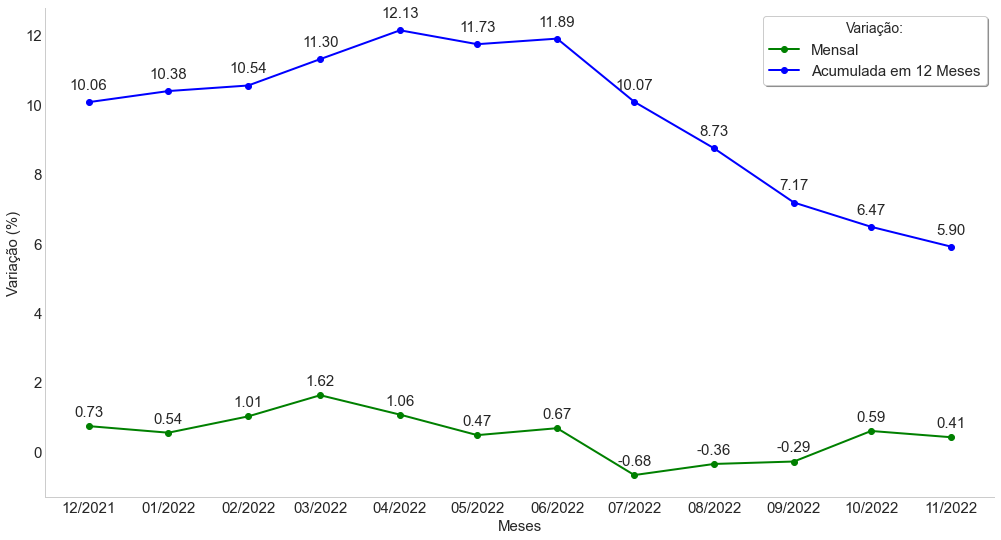

In [ ]:
plt.style.use('seaborn-whitegrid')

ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(ipca_brasil['IPCA - Variação mensal'], label = 'Mensal', linewidth=2, marker='o', color='green')
fig.plot(ipca_brasil['IPCA - Variação acumulada em 12 meses'], label = 'Acumulada em 12 Meses', linewidth=2, marker='o', color='blue')

plt.grid(b=None)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='best',
    ncol = 1,
    #bbox_to_anchor=(0.70,0.55),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)

# Hide the right and top spines
fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)

plt.yticks(fontsize=15)
str_month_list = list(ipca_brasil.index.strftime("%m/%Y"))
plt.xticks(ipca_brasil.index,str_month_list, fontsize=15)

# Remove all spines

# Valores em cada ponto do gráfico
for x,y in zip(ipca_brasil['IPCA - Variação mensal'].index,ipca_brasil['IPCA - Variação mensal'].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

for x,y in zip(ipca_brasil['IPCA - Variação acumulada em 12 meses'].index,ipca_brasil['IPCA - Variação acumulada em 12 meses'].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,13), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 1 - IPCA 12M E MENSAL.svg', dpi=600)

plt.show()

#### Acumulado no Ano

In [ ]:
#criar uma variável com os 12 meses do ano atual com o pacote datetime
ano_atual = dt.datetime.now().year
meses_ano_atual = pd.date_range(start=f'{ano_atual}-01-01', end=f'{ano_atual}-12-01', freq='MS')
df_vazio = pd.DataFrame(meses_ano_atual) #variável auxiliar para criar meses futuros no gráfico da variação acumulada.

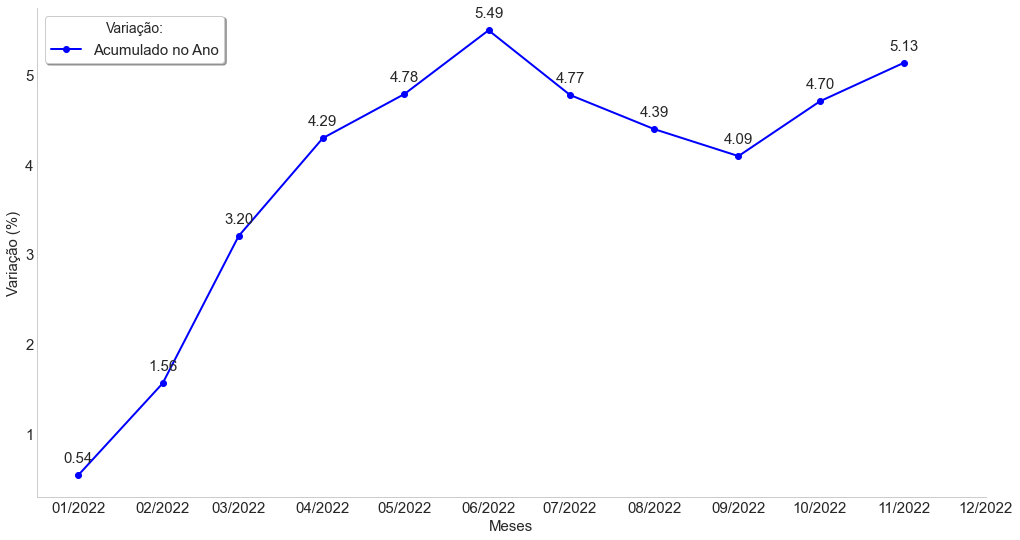

In [ ]:
plt.style.use('seaborn-whitegrid')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(
    ipca_brasil[ipca_brasil.index >= df_vazio[0][0]]['IPCA - Variação acumulada no ano'],
    marker='o', 
    label = 'Acumulado no Ano', 
    linewidth=2, 
    color='blue')

#fig.set_title('Variação Acumulado no Ano do IPCA')

plt.grid(False)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    #bbox_to_anchor=(0.05,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)

fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)

# Hide the right and top spines
fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)

plt.yticks(fontsize=15)
str_month_list = list(meses_ano_atual.strftime("%m/%Y"))
plt.xticks(meses_ano_atual,str_month_list, fontsize=15)

# Valores em cada ponto do gráfico
for x,y in zip(ipca_brasil['IPCA - Variação acumulada no ano'].index, ipca_brasil['IPCA - Variação acumulada no ano'].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,13), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center
plt.savefig('graficos/GRÁFICO 2 - IPCA NO ANO.svg', dpi=600)

plt.show()

### Regiões <a id="graficos-ipca-regioes"></a>

[Voltar](#nav)

Seleciona somente as linha com a variação regional, inverte, e renomeia as colunas

Preenchimento da tabela no Excel

In [ ]:
workbook = oxl.load_workbook(filename='tabela_regioes.xlsx')

In [ ]:
sheet = workbook.active

In [ ]:
for i in ipca_regioes.index:
    sheet[f"A{i+4}"] = ipca_regioes.loc[i,'Brasil, Região Metropolitana e Município']
    sheet[f"B{i+4}"] = ipca_regioes.loc[i,'Peso']
    sheet[f"C{i+4}"] = ipca_regioes.loc[i,'IPCA - Variação mensal - anterior']
    sheet[f"D{i+4}"] = ipca_regioes.loc[i,'IPCA - Variação mensal - atual']
    sheet[f"E{i+4}"] = ipca_regioes.loc[i,'IPCA - Variação acumulada no ano']
    sheet[f"F{i+4}"] = ipca_regioes.loc[i,'IPCA - Variação acumulada em 12 meses']

sheet[f"A20"] = 'Brasil'
sheet[f"B20"] = 100.00
sheet[f"C20"] = ipca_brasil.loc[data_anterior,'IPCA - Variação mensal'][0]
sheet[f"D20"] = ipca_brasil.loc[data_atual,'IPCA - Variação mensal'][0]
sheet[f"E20"] = ipca_brasil.loc[data_atual,'IPCA - Variação acumulada no ano'][0]
sheet[f"F20"] = ipca_brasil.loc[data_atual,'IPCA - Variação acumulada em 12 meses'][0]

In [ ]:
workbook.save(filename="tabelas\IPCA REGIÕES.xlsx")

### Curitiba <a id="graficos-ipca-curitiba"></a>

[Voltar](#nav)

Preenchimento da tabela no Excel

In [ ]:
workbook = oxl.load_workbook(filename='tabela_curitiba.xlsx') #Substituir Valores no Excel

In [ ]:
sheet = workbook.active

In [ ]:
#Preenche a tabela das categorias do ipca de curitiba
for i in ipca_curitiba.index:
    sheet[f"A{i+4}"] = ipca_curitiba.loc[i, 'Geral, grupo, subgrupo, item e subitem']
    sheet[f"B{i+4}"] = ipca_curitiba.loc[i, 'IPCA - Variação mensal - anterior']
    sheet[f"C{i+4}"] = ipca_curitiba.loc[i, 'IPCA - Variação mensal - atual']
    sheet[f"D{i+4}"] = ipca_curitiba.loc[i, 'IPCA - Variação acumulada no ano']
    sheet[f"E{i+4}"] = ipca_curitiba.loc[i, 'IPCA - Variação acumulada em 12 meses']


In [ ]:
workbook.save(filename="tabelas\IPCA CURITIBA.xlsx")

## INPC <a id="graficos-inpc"></a>

[Voltar](#nav)

### Brasil <a id="graficos-inpc-nacional"></a>

[Voltar](#nav)

#### Acumulado 12 Meses e Variação Mensal

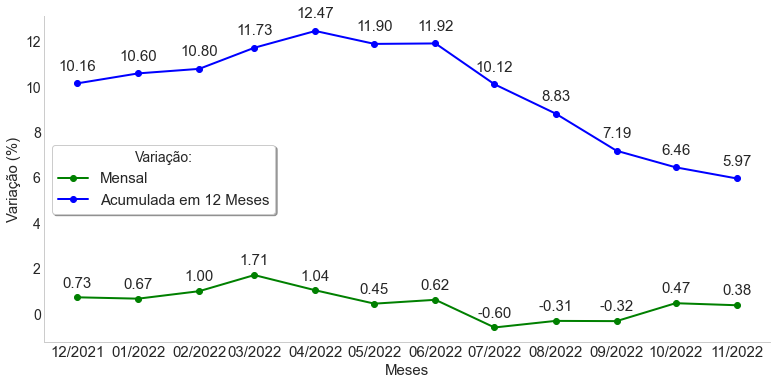

In [ ]:
plt.style.use('seaborn-whitegrid')

ax, fig = plt.subplots(figsize=(13, 6))
fig.plot(
    inpc_brasil['INPC - Variação mensal'], 
    label = 'Mensal', 
    linewidth=2, 
    marker='o', 
    color='green')

fig.plot(
    inpc_brasil['INPC - Variação acumulada em 12 meses'], 
    label = 'Acumulada em 12 Meses', 
    linewidth=2, 
    marker='o', 
    color='blue')
#fig.set_title('Variação Mensal e Acumulada dos Últimos 12 meses do INPC')

plt.grid(False)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='center left',
    ncol = 1,
    #bbox_to_anchor=(0.65,0.55),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)

# Hide the right and top spines
fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)

plt.yticks(fontsize=14)
plt.xticks(fontsize=12)

str_month_list = list(inpc_brasil.index.strftime("%m/%Y"))
plt.xticks(inpc_brasil.index,str_month_list, fontsize=15)

# Valores em cada ponto do gráfico
for x,y in zip(inpc_brasil['INPC - Variação mensal'].index, inpc_brasil['INPC - Variação mensal'].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

for x,y in zip(inpc_brasil['INPC - Variação acumulada em 12 meses'].index, inpc_brasil['INPC - Variação acumulada em 12 meses'].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,13), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 3 - INPC 12M E MENSAL.svg', dpi=600)

plt.show()

#### Acumulado no Ano

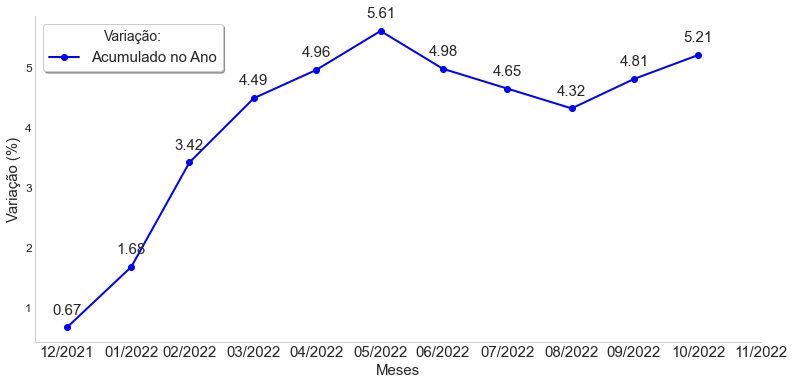

In [ ]:
plt.style.use('seaborn-whitegrid')
ax, fig = plt.subplots(figsize=(13, 6))

fig.plot(
    inpc_brasil[inpc_brasil.index >= df_vazio[0][0]]['INPC - Variação acumulada no ano'],
    marker='o', 
    label = 'Acumulado no Ano', 
    linewidth=2, 
    color='blue')

#fig.set_title('Variação Acumulada no Ano INPC')

plt.grid(False)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    #bbox_to_anchor=(0.05,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)

fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)

fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.xticks(meses_ano_atual, str_month_list, fontsize=15)

# Valores em cada ponto do gráfico
for x,y in zip(inpc_brasil['INPC - Variação acumulada no ano'].index, inpc_brasil['INPC - Variação acumulada no ano'].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,13), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 4 - INPC NO ANO.svg')

plt.show()

### Regiões <a id="graficos-inpc-regioes"></a>

[Voltar](#nav)

Preechimento da tabela no Excel

In [ ]:
workbook = oxl.load_workbook(filename='tabela_regioes.xlsx')

In [ ]:
sheet = workbook.active

In [ ]:
#Preenche a tabela das categorias do inpc de curitiba
for i in inpc_regioes.index:
    sheet[f"A{i+4}"] = inpc_regioes.loc[i,'Brasil, Região Metropolitana e Município']
    sheet[f"B{i+4}"] = inpc_regioes.loc[i,'Peso']
    sheet[f"C{i+4}"] = inpc_regioes.loc[i,'INPC - Variação mensal - anterior']
    sheet[f"D{i+4}"] = inpc_regioes.loc[i,'INPC - Variação mensal - atual']
    sheet[f"E{i+4}"] = inpc_regioes.loc[i,'INPC - Variação acumulada no ano']
    sheet[f"F{i+4}"] = inpc_regioes.loc[i,'INPC - Variação acumulada em 12 meses']

sheet[f"A20"] = 'Brasil'
sheet[f"B20"] = 100.00
sheet[f"C20"] = inpc_brasil.loc[data_anterior,'INPC - Variação mensal'][0]
sheet[f"D20"] = inpc_brasil.loc[data_atual,'INPC - Variação mensal'][0]
sheet[f"E20"] = inpc_brasil.loc[data_atual,'INPC - Variação acumulada no ano'][0]
sheet[f"F20"] = inpc_brasil.loc[data_atual,'INPC - Variação acumulada em 12 meses'][0]

In [ ]:
workbook.save(filename="tabelas/INPC REGIÕES.xlsx")

### Curitiba <a id="graficos-inpc-curitiba"></a>

[Voltar](#nav)

Preenchimento da tabela no Excel

In [ ]:
workbook = oxl.load_workbook(filename='tabela_curitiba.xlsx')

In [ ]:
sheet = workbook.active

In [ ]:
#Preenche a tabela das categorias do ipca de curitiba
for i in inpc_curitiba.index:
    sheet[f"A{i+4}"] = inpc_curitiba.loc[i,'Geral, grupo, subgrupo, item e subitem']
    sheet[f"B{i+4}"] = inpc_curitiba.loc[i,'INPC - Variação mensal - anterior']
    sheet[f"C{i+4}"] = inpc_curitiba.loc[i,'INPC - Variação mensal - atual']
    sheet[f"D{i+4}"] = inpc_curitiba.loc[i,'INPC - Variação acumulada no ano']
    sheet[f"E{i+4}"] = inpc_curitiba.loc[i,'INPC - Variação acumulada em 12 meses']


In [ ]:
workbook.save(filename="tabelas/INPC CURITIBA.xlsx")

## Preços Monitorados <a id="graficos-monitorados"></a>

[Voltar](#nav)

### Variação mensal e acumulada em 12 meses do IPCA E INPC

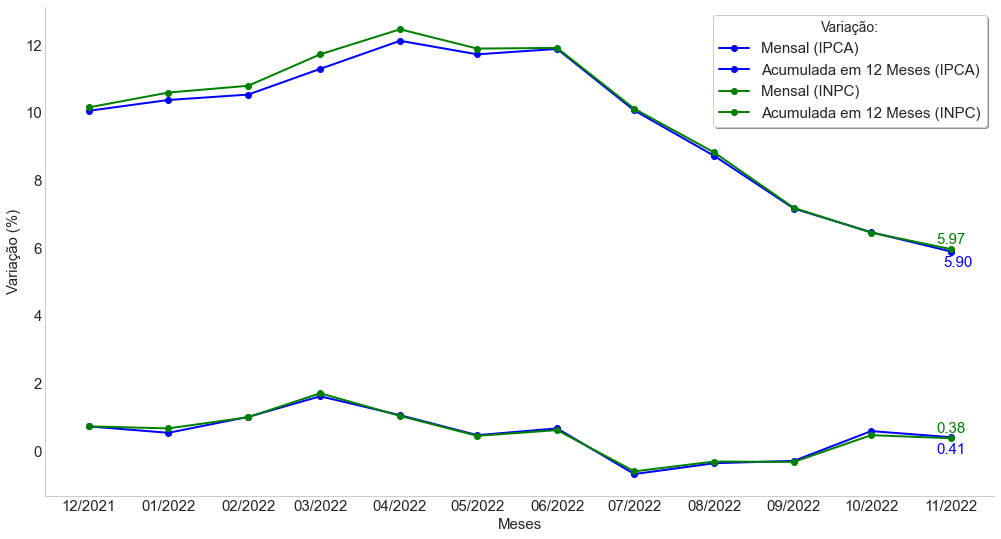

In [ ]:
ax, fig = plt.subplots(figsize=(17, 9))

fig.plot(ipca_brasil['IPCA - Variação mensal'], label = 'Mensal (IPCA)', linewidth=2, color='blue', marker='o')
fig.plot(ipca_brasil['IPCA - Variação acumulada em 12 meses'], label = 'Acumulada em 12 Meses (IPCA)', linewidth=2, color='blue', marker='o')

fig.plot(inpc_brasil['INPC - Variação mensal'], label = 'Mensal (INPC)', linewidth=2, color='green', marker='o')
fig.plot(inpc_brasil['INPC - Variação acumulada em 12 meses'], label = 'Acumulada em 12 Meses (INPC)', linewidth=2, color='green', marker='o')

plt.grid(False)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='best',
    ncol = 1,
    #bbox_to_anchor=(0.65,0.50),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)

str_month_list = list(inpc_brasil.index[-12:].strftime("%m/%Y"))
plt.xticks(inpc_brasil.iloc[-12:].index,str_month_list, fontsize=15)

# Valores em cada ponto do gráfico
for x,y in zip(ipca_brasil['IPCA - Variação mensal'][-1:].index,ipca_brasil['IPCA - Variação mensal'][-1:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-17), # distance from text to points (x,y)
                 ha='center',
                 size=15,
                 color='blue') # horizontal alignment can be left, right or center

for x,y in zip(ipca_brasil['IPCA - Variação acumulada em 12 meses'][-1:].index, ipca_brasil['IPCA - Variação acumulada em 12 meses'][-1:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(7,-15), # distance from text to points (x,y)
                 ha='center',
                 size=15,
                 color='blue') # horizontal alignment can be left, right or center

# Valores em cada ponto do gráfico
for x,y in zip(inpc_brasil['INPC - Variação mensal'][-1:].index,inpc_brasil['INPC - Variação mensal'][-1:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,5), # distance from text to points (x,y)
                ha='center',
                size=15,
                color='green') # horizontal alignment can be left, right or center

for x,y in zip(inpc_brasil['INPC - Variação acumulada em 12 meses'][-1:].index, inpc_brasil['INPC - Variação acumulada em 12 meses'][-1:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,5), # distance from text to points (x,y)
                ha='center',
                size=15,
                color='green') # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 5 - IPCA X INPC VAR 12M.svg', dpi=600)

plt.show()

### Variação acumulada em 12 meses de itens selecionados

In [ ]:
X = precos_monitorados['Geral, grupo, subgrupo, item e subitem'].values
ipca_monitorado = precos_monitorados['IPCA - Variação acumulada em 12 meses'].values
inpc_monitorado = precos_monitorados['INPC - Variação acumulada em 12 meses'].values

X_axis = np.arange(len(X))


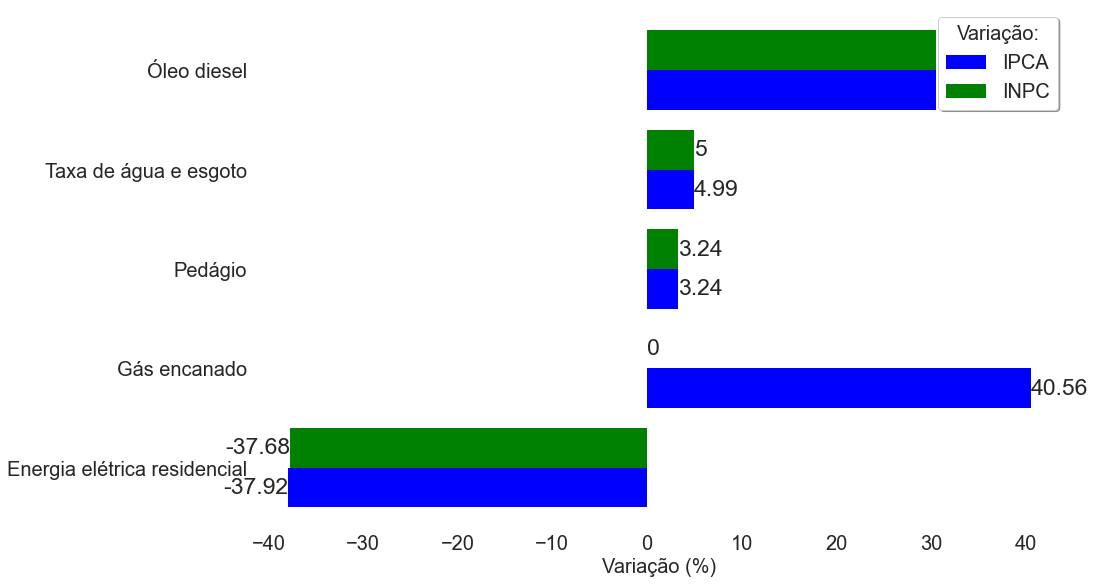

In [ ]:
ax, fig = plt.subplots(figsize=(15, 7.92))
baripca = plt.barh(X_axis - 0.2, ipca_monitorado, 0.4, label = 'IPCA', color='blue')
barinpc = plt.barh(X_axis + 0.2, inpc_monitorado, 0.4, label = 'INPC', color='green')

fig.set_frame_on(False)

plt.yticks(X_axis, X)

plt.yticks(fontsize=15)
plt.xticks(fontsize=14)

plt.bar_label(baripca, fontsize=23)
plt.bar_label(barinpc, fontsize=23)

plt.grid(False)

plt.legend(
    title='Variação:',
    title_fontsize=20,
    loc='best',
    ncol = 1,
    #bbox_to_anchor=(0.70,0.70),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=20)
fig.set_xlabel('Variação (%)', fontsize=20)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.tight_layout(pad=0)



plt.savefig('graficos/GRÁFICO 6 - PREÇOS MONITORADOS.svg', dpi=600)

plt.show()

## IGP-DI <a id="graficos-igpdi"></a>

[Voltar](#nav)

AttributeError: 'Index' object has no attribute 'strftime'

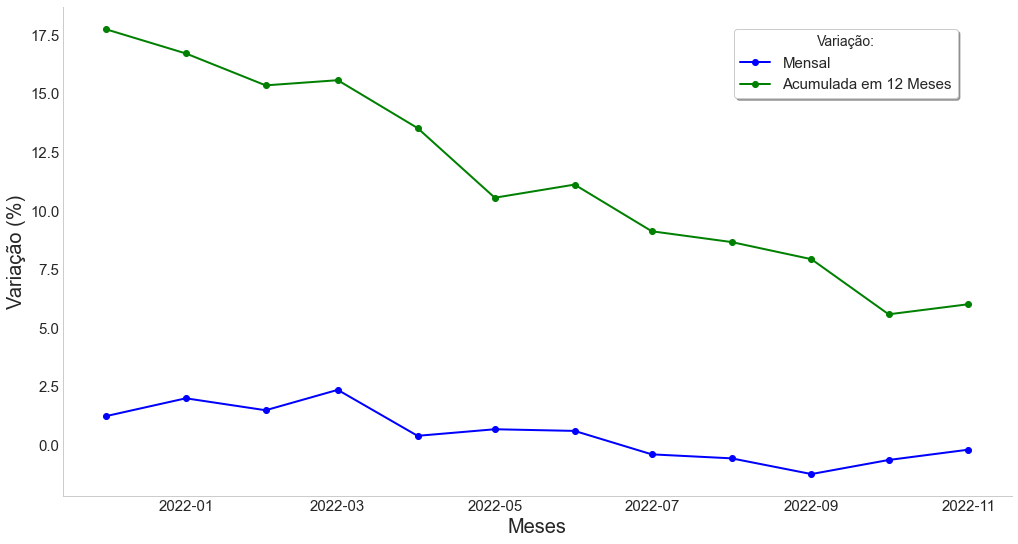

In [ ]:
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(igpdi.iloc[-12:,1], label = 'Mensal', linewidth=2, marker='o', color='blue')
fig.plot(igpdi.iloc[-12:,2], label = 'Acumulada em 12 Meses', linewidth=2, marker='o', color='green')
#fig.set_title('Variação Mensal e Acumulada dos Últimos 12 meses do IGP-DI')

fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)


plt.grid(False)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.70,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=20)
fig.set_ylabel('Variação (%)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

str_month_list = list(igpdi.index[-12:].strftime("%m/%Y"))
plt.xticks(igpdi.iloc[-12:].index,str_month_list, fontsize=15)


# Valores em cada ponto do gráfico
for x,y in zip(igpdi['Variação Mensal'][-12:].index,igpdi['Variação Mensal'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

for x,y in zip(igpdi['Acumulado 12 meses'][-12:].index,igpdi['Acumulado 12 meses'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,13), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center
plt.savefig('graficos/GRÁFICO 7 - IGP-DI.svg', dpi=600)

plt.show()

## IGP-M <a id="graficos-igpm"></a>

[Voltar](#nav)

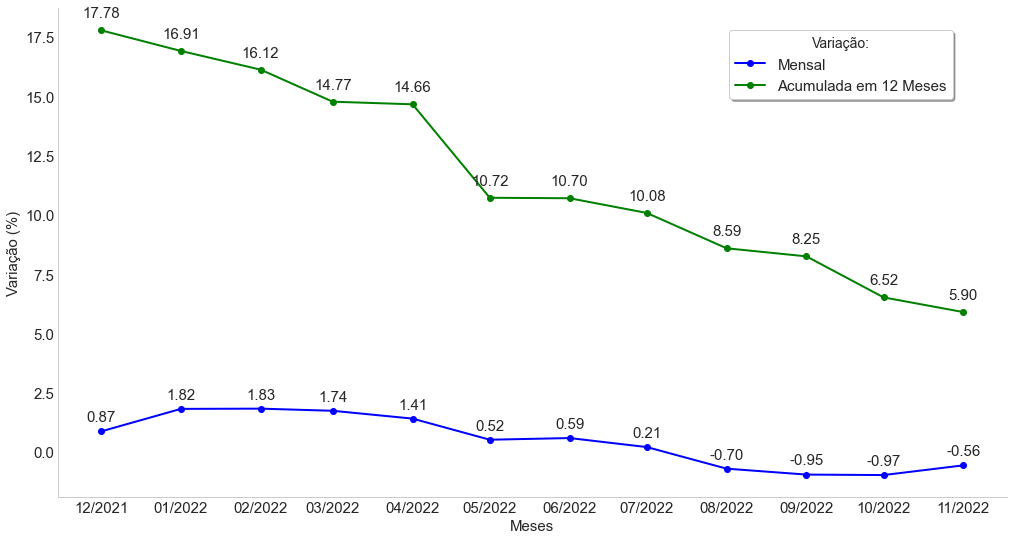

In [ ]:
plt.style.use('seaborn-whitegrid')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(igpm.iloc[-12:,1], label = 'Mensal', linewidth=2, marker='o', color='blue')
fig.plot(igpm.iloc[-12:,2], label = 'Acumulada em 12 Meses', linewidth=2, marker='o', color='green')
#fig.set_title('Variação Mensal e Acumulada dos Últimos 12 meses do IGP-M')

fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)

plt.grid(False)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.70,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

str_month_list = list(igpm.index[-12:].strftime("%m/%Y"))
plt.xticks(igpm.iloc[-12:].index,str_month_list, fontsize=15)

# Valores em cada ponto do gráfico
for x,y in zip(igpm['Variação Mensal'][-12:].index, igpm['Variação Mensal'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

for x,y in zip(igpm['Acumulado 12 meses'][-12:].index, igpm['Acumulado 12 meses'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,13), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 8 - IGP-M.svg', dpi=600)

plt.show()

## Brent <a id="graficos-brent"></a>

[Voltar](#nav)

In [ ]:
brent.dropna(inplace=True)

In [ ]:
meses_ano_atual

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
#filtrar brent com os 12 meses do ano atual
brent_12meses = brent[brent.date.isin(meses_ano_atual)]
brent_12meses['date'] = pd.to_datetime(brent_12meses['date'])
brent_12meses.set_index('date', inplace=True)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19424\2547867570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_12meses['date'] = pd.to_datetime(brent_12meses['date'])


In [ ]:
brent_12meses = brent[(brent['date'] > '2021-11-01') & (brent['date'] < '2022-12-01')]

In [ ]:
brent_12meses.set_index('date', inplace=True)

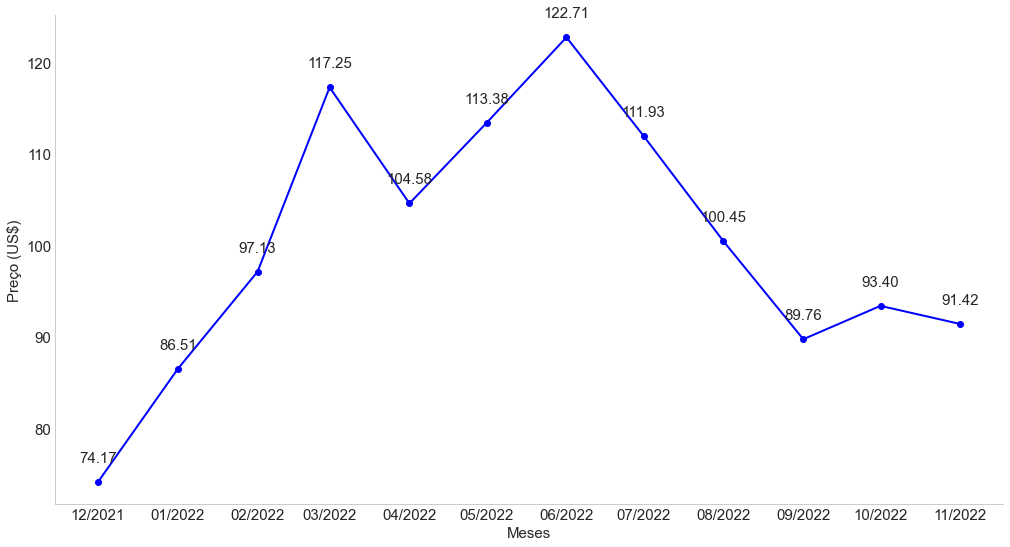

In [ ]:
plt.style.use('seaborn-whitegrid')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(brent_12meses, label = 'Mensal', linewidth=2, marker='o', color='blue')
#fig.set_title('Evolução do Preço por Barril de Petróleo Bruto Tipo Brent - Em US$ (FOB)')
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Preço (US$)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)

plt.grid(False)

str_month_list = list(brent_12meses.index.strftime("%m/%Y"))
plt.xticks(brent_12meses.index,str_month_list, fontsize=15)

# Valores em cada ponto do gráfico
for x, y in zip(brent_12meses.index, brent_12meses.price.values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,20), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 9 - BRENT.svg', dpi=600)

plt.show()

## Diesel-S10 <a id="graficos-diesel"></a>

[Voltar](#nav)

## Capitais <a id="graficos-diesel-capitais"></a>

[Voltar](#nav)

In [19]:
precos_capitais.reset_index(inplace=True)

In [22]:
precos_capitais.sort_values(by='MÉDIA', inplace=True)

In [23]:
precos_capitais

MÊS,MUNICÍPIO,2022-09,2022-10,2022-11,MÉDIA
8,PORTO ALEGRE,6.75,6.41,6.43,6.53
4,CAMPO GRANDE,6.80,6.52,6.54,6.62
9,RECIFE,6.68,6.59,6.59,6.62
5,CURITIBA,6.75,6.59,6.64,6.66
11,RIO DE JANEIRO,6.90,6.60,6.57,6.69
14,SAO PAULO,6.87,6.61,6.63,6.70
2,BELO HORIZONTE,6.90,6.63,6.59,6.71
13,SAO LUIS,6.78,6.61,6.75,6.71
0,ARACAJU,6.65,6.73,6.86,6.75
3,BRASILIA,6.90,6.68,6.81,6.80


In [24]:
precos_capitais.iloc[0,0]

'PORTO ALEGRE'

In [28]:
workbook = oxl.load_workbook(filename='PREÇO DIESEL REGIOES.xlsx')
sheet = workbook.active
#Preenche a tabela das categorias do inpc de curitiba
for i in precos_capitais.index:
    sheet[f"A{i+4}"] = precos_capitais.iloc[i,0] #capitais
    sheet[f"B{i+4}"] = precos_capitais.iloc[i,1] #mês 1
    sheet[f"C{i+4}"] = precos_capitais.iloc[i,2] #mês 2
    sheet[f"D{i+4}"] = precos_capitais.iloc[i,3] #mês 3
    sheet[f"E{i+4}"] = precos_capitais.iloc[i,4] #média


workbook.save(filename='tabelas/PREÇO DIESEL REGIOES.xlsx')


### Curitiba <a id="graficos-diesel-curitiba"></a>

[Voltar](#nav)

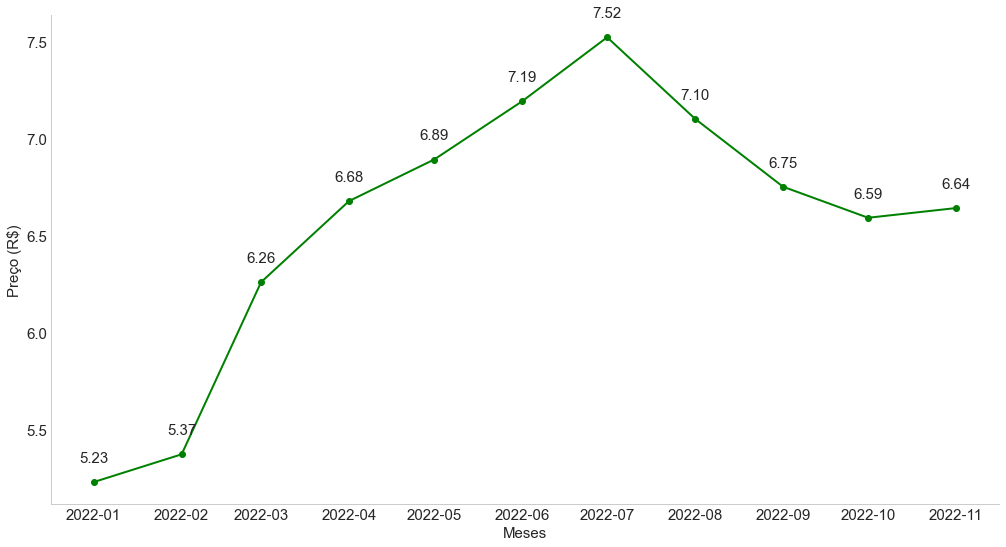

In [16]:
plt.style.use('seaborn-whitegrid')
ax, fig = plt.subplots(figsize=(17,9))
fig.plot(diesel_curitiba['PREÇO MÉDIO REVENDA'], linewidth=2, marker='o', color='green') #variação de preço curitiba

fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Preço (R$)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.xticks(x.iloc[-12:].index,str_month_list, fontsize=15)

plt.grid(False)

fig.spines.right.set_visible(False)
fig.spines.top.set_visible(False)

# Valores em cada ponto do gráfico
for x,y in zip(diesel_curitiba['PREÇO MÉDIO REVENDA'].index, diesel_curitiba['PREÇO MÉDIO REVENDA'].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,20), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 10 - DIESEL CURITIBA.svg', dpi=600)

plt.show()

### Regiões <a id="graficos-diesel-regioes"></a>

[Voltar](#nav)

In [81]:
DataInicialReferencia = precos_semanal['DATA INICIAL'].max().strftime("%d/%m/%Y")
DataFinalReferencia = precos_semanal['DATA FINAL'].max().strftime("%d/%m/%Y")

In [70]:
variacao_regiao.reset_index(inplace=True)

In [71]:
variacao_regiao.index.values

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [82]:
workbook = oxl.load_workbook(filename='REGIÕES DO BRASIL MODELO.xlsx')
sheet = workbook.active
#Preenche a tabela das categorias do inpc de curitiba
for i in variacao_regiao.index.values:
    sheet[f"B{i+5}"] = variacao_regiao.loc[i,'REGIÃO'] 
    sheet[f"C{i+5}"] = variacao_regiao.loc[i,'PREÇO MÉDIO REVENDA'] 
    sheet[f"D{i+5}"] = variacao_regiao.loc[i,'SEMANAL']
    sheet[f"E{i+5}"] = variacao_regiao.loc[i,'MENSAL'] 
    sheet[f"F{i+5}"] = variacao_regiao.loc[i,'SEIS MESES'] 

sheet['C12'] = DataInicialReferencia
sheet['D12'] = DataFinalReferencia

workbook.save(filename='tabelas/REGIÕES DO BRASIL.xlsx')